In [146]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [147]:
%cd /content/drive/MyDrive/CS5100

/content/drive/MyDrive/CS5100


In [148]:
# Install openyxl for xlsx files since Pandas no longer supports them natively
!pip install openpyxl

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import random
import itertools
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img,img_to_array

from keras.utils import to_categorical
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Reshape, Dropout
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping


## models to import
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

## Constants for data preparation

In [149]:
## for VGG pre-trained model it only accepts a 224 x 224 image size
img_size = 224

## Import image description data

In [150]:
# open csv file (note - target and filename only references one single eye)

df_data = pd.read_csv("/content/drive/MyDrive/CS5100/full_df.csv")
df_data.head()

ID  Patient Age Patient Sex Left-Fundus Right-Fundus  \
0   0           69      Female  0_left.jpg  0_right.jpg   
1   1           57        Male  1_left.jpg  1_right.jpg   
2   2           42        Male  2_left.jpg  2_right.jpg   
3   4           53        Male  4_left.jpg  4_right.jpg   
4   5           50      Female  5_left.jpg  5_right.jpg   

                            Left-Diagnostic Keywords  \
0                                           cataract   
1                                      normal fundus   
2  laser spot，moderate non proliferative retinopathy   
3                        macular epiretinal membrane   
4             moderate non proliferative retinopathy   

                Right-Diagnostic Keywords  N  D  G  C  A  H  M  O  \
0                           normal fundus  0  0  0  1  0  0  0  0   
1                           normal fundus  1  0  0  0  0  0  0  0   
2  moderate non proliferative retinopathy  0  1  0  0  0  0  0  1   
3       mild nonproliferative retinopathy  0  1  0  0  0  0  0  1   
4  moderate non proliferative retinopathy  0  1  0  0  0  0  0  0   

                                            filepath labels  \
0  ../input/ocular-disease-recognition-odir5k/ODI...  ['N']   
1  ../input/ocular-disease-recognition-odir5k/ODI...  ['N']   
2  ../input/ocular-disease-recognition-odir5k/ODI...  ['D']   
3  ../input/ocular-disease-recognition-odir5k/ODI...  ['D']   
4  ../input/ocular-disease-recognition-odir5k/ODI...  ['D']   

                     target     filename  
0  [1, 0, 0, 0, 0, 0, 0, 0]  0_right.jpg  
1  [1, 0, 0, 0, 0, 0, 0, 0]  1_right.jpg  
2  [0, 1, 0, 0, 0, 0, 0, 0]  2_right.jpg  
3  [0, 1, 0, 0, 0, 0, 0, 0]  4_right.jpg  
4  [0, 1, 0, 0, 0, 0, 0, 0]  5_right.jpg

### Ocular disease map

* Normal (N),
* Diabetes (D),
* Glaucoma (G),
* Cataract (C),
* Age related Macular Degeneration (A),
* Hypertension (H),
* Pathological Myopia (M),
* Other diseases/abnormalities (O)

### Exploratory data analysis

One big issue with this data set is that it has images for BOTH left and right eyes in separate files, which totally makes sense since as humans we have two eyes.  However, in the numeric encoded diagnosis (the columns labeled C, D, G...) it doesn't specify the left or right eye, the logic is that if there was any eye with an issue, then a 'true' '1' would result.  '1' doesn't tell us if this was a left or right eye, and in some queries this doesn't matter, but when we pull our image files, this becomes and issue.

We really need to go by the data from the keyword diagnosis, if there is a

Let's take a look at the keywords of images that have a cataract diagnosis

In [151]:
df_data[df_data.C==1].head()

ID  Patient Age Patient Sex   Left-Fundus   Right-Fundus  \
0     0           69      Female    0_left.jpg    0_right.jpg   
20   24           75      Female   24_left.jpg   24_right.jpg   
65   81           66        Male   81_left.jpg   81_right.jpg   
86  103           55      Female  103_left.jpg  103_right.jpg   
93  112           57      Female  112_left.jpg  112_right.jpg   

                           Left-Diagnostic Keywords  \
0                                          cataract   
20                                    normal fundus   
65  moderate non proliferative retinopathy，cataract   
86                                         cataract   
93                                    normal fundus   

                          Right-Diagnostic Keywords  N  D  G  C  A  H  M  O  \
0                                     normal fundus  0  0  0  1  0  0  0  0   
20                                         cataract  0  0  0  1  0  0  0  0   
65  moderate non proliferative retinopathy，cataract  0  1  0  1  0  0  0  0   
86                                    normal fundus  0  0  0  1  0  0  0  0   
93                                         cataract  0  0  0  1  0  0  0  0   

                                             filepath labels  \
0   ../input/ocular-disease-recognition-odir5k/ODI...  ['N']   
20  ../input/ocular-disease-recognition-odir5k/ODI...  ['C']   
65  ../input/ocular-disease-recognition-odir5k/ODI...  ['D']   
86  ../input/ocular-disease-recognition-odir5k/ODI...  ['N']   
93  ../input/ocular-disease-recognition-odir5k/ODI...  ['C']   

                      target       filename  
0   [1, 0, 0, 0, 0, 0, 0, 0]    0_right.jpg  
20  [0, 0, 0, 1, 0, 0, 0, 0]   24_right.jpg  
65  [0, 1, 0, 0, 0, 0, 0, 0]   81_right.jpg  
86  [1, 0, 0, 0, 0, 0, 0, 0]  103_right.jpg  
93  [0, 0, 0, 1, 0, 0, 0, 0]  112_right.jpg

It seems safe to say that if either eye has a cataract, then it is properly labeled in the keywords column of that eye with the word "cataract".  At this point, it's safe to go ahead and ignore the encoded columns since they simply don't provide accurate mapping to our left/right eye requirements when we process the left/right images.

In [152]:
# df_data.info()

### Find the number of positive "1" results in the dataset.  

We will look at the columns (this is the axis=0 flag) and count all the '1' in it.

In [153]:
df_data[df_data == 1].sum(axis=0)

ID                              2.0
Patient Age                    28.0
Patient Sex                       0
Left-Fundus                       0
Right-Fundus                      0
Left-Diagnostic Keywords          0
Right-Diagnostic Keywords         0
N                            2101.0
D                            2123.0
G                             397.0
C                             402.0
A                             319.0
H                             203.0
M                             306.0
O                            1588.0
filepath                          0
labels                            0
target                            0
filename                          0
dtype: object

## Problems with the encoded categories

Relying on the encoded diagnosis categories "N	D	G	C	A	H	M	O" could be problematic in the sense that some of the values were positive for both normal and disease eyes, but didn't specify which eye. The problem with this is that the files and diagnosis are orientation specific and the row of data contains both eyes information.  If I use the categories exclusively,  run into the problem later on where pulling specific eye orientation data is impossible as it is lost in the encoded categories.  

Therefore I will exclude those categories for this notebook although they could certainly be used for other investigations.

In [154]:
df_data2 = df_data.iloc[:, 1:7]
# df_data2['filepath'] = pd.Series(df_data['filepath'])
df_data2.head()

Patient Age Patient Sex Left-Fundus Right-Fundus  \
0           69      Female  0_left.jpg  0_right.jpg   
1           57        Male  1_left.jpg  1_right.jpg   
2           42        Male  2_left.jpg  2_right.jpg   
3           53        Male  4_left.jpg  4_right.jpg   
4           50      Female  5_left.jpg  5_right.jpg   

                            Left-Diagnostic Keywords  \
0                                           cataract   
1                                      normal fundus   
2  laser spot，moderate non proliferative retinopathy   
3                        macular epiretinal membrane   
4             moderate non proliferative retinopathy   

                Right-Diagnostic Keywords  
0                           normal fundus  
1                           normal fundus  
2  moderate non proliferative retinopathy  
3       mild nonproliferative retinopathy  
4  moderate non proliferative retinopathy

In [155]:
# Extract image paths and labels
left_fundus_images = df_data2['Left-Fundus'].tolist()
left_diagnostic_keywords = df_data2['Left-Diagnostic Keywords'].tolist()
left_diagnostic_keywords

['cataract',
 'normal fundus',
 'laser spot，moderate non proliferative retinopathy',
 'macular epiretinal membrane',
 'moderate non proliferative retinopathy',
 'macular epiretinal membrane',
 'drusen',
 'normal fundus',
 'normal fundus',
 'epiretinal membrane',
 'moderate non proliferative retinopathy，hypertensive retinopathy',
 'pathological myopia',
 'normal fundus',
 'normal fundus',
 'normal fundus',
 'drusen',
 'pathological myopia',
 'mild nonproliferative retinopathy',
 'epiretinal membrane',
 'hypertensive retinopathy',
 'normal fundus',
 'moderate non proliferative retinopathy',
 'normal fundus',
 'hypertensive retinopathy',
 'epiretinal membrane',
 'epiretinal membrane',
 'hypertensive retinopathy',
 'normal fundus',
 'drusen',
 'pathological myopia',
 'macular epiretinal membrane，mild nonproliferative retinopathy',
 'macular hole',
 'macular epiretinal membrane',
 'normal fundus',
 'wet age-related macular degeneration',
 'moderate non proliferative retinopathy，laser spot',

## Set up file paths



In [156]:
img_dir = "/content/drive/MyDrive/CS5100/preprocessed_images"

** JUST TRIED TO ADD 'glaucoma'BUT IT GAVE LOW ACURACY!**

In [157]:
# Left diagnosis with 'glaucoma' keyword

df_data2[df_data2['Left-Diagnostic Keywords'].str.match('glaucoma')].head()

Patient Age Patient Sex    Left-Fundus    Right-Fundus  \
129           79        Male   153_left.jpg   153_right.jpg   
141           71        Male   167_left.jpg   167_right.jpg   
510           54        Male   583_left.jpg   583_right.jpg   
986           69      Female  1209_left.jpg  1209_right.jpg   
987           62        Male  1210_left.jpg  1210_right.jpg   

    Left-Diagnostic Keywords             Right-Diagnostic Keywords  
129                 glaucoma  dry age-related macular degeneration  
141                 glaucoma                              glaucoma  
510                 glaucoma                              glaucoma  
986                 glaucoma                              glaucoma  
987                 glaucoma                              glaucoma

In [158]:
## let's place the left cataract data into its own dataframe and print the number of rows

df_left_gla = df_data2[df_data2['Left-Diagnostic Keywords'].str.match('glaucoma')]
print(len(df_left_gla))

262


In [159]:
# Right diagnosis with 'glaucoma' keyword

df_data[df_data['Right-Diagnostic Keywords'].str.match('glaucoma')].head()

ID  Patient Age Patient Sex    Left-Fundus    Right-Fundus  \
141   167           71        Male   167_left.jpg   167_right.jpg   
510   583           54        Male   583_left.jpg   583_right.jpg   
986  1209           69      Female  1209_left.jpg  1209_right.jpg   
987  1210           62        Male  1210_left.jpg  1210_right.jpg   
988  1211           80        Male  1211_left.jpg  1211_right.jpg   

         Left-Diagnostic Keywords     Right-Diagnostic Keywords  N  D  G  C  \
141                      glaucoma                      glaucoma  0  0  1  0   
510                      glaucoma                      glaucoma  0  0  1  0   
986                      glaucoma                      glaucoma  0  0  1  0   
987                      glaucoma                      glaucoma  0  0  1  0   
988  glaucoma，optic nerve atrophy  glaucoma，optic nerve atrophy  0  0  1  0   

     A  H  M  O                                           filepath labels  \
141  0  0  0  0  ../input/ocular-disease-recognition-odir5k/ODI...  ['G']   
510  0  0  0  0  ../input/ocular-disease-recognition-odir5k/ODI...  ['G']   
986  0  0  0  0  ../input/ocular-disease-recognition-odir5k/ODI...  ['G']   
987  0  0  0  0  ../input/ocular-disease-recognition-odir5k/ODI...  ['G']   
988  0  0  0  1  ../input/ocular-disease-recognition-odir5k/ODI...  ['G']   

                       target        filename  
141  [0, 0, 1, 0, 0, 0, 0, 0]   167_right.jpg  
510  [0, 0, 1, 0, 0, 0, 0, 0]   583_right.jpg  
986  [0, 0, 1, 0, 0, 0, 0, 0]  1209_right.jpg  
987  [0, 0, 1, 0, 0, 0, 0, 0]  1210_right.jpg  
988  [0, 0, 1, 0, 0, 0, 0, 0]  1211_right.jpg

In [160]:
df_rt_gla = df_data2[df_data2['Right-Diagnostic Keywords'].str.match('glaucoma')]
print(len(df_rt_gla))

232


In [161]:
df_gla_filenames = pd.concat([df_left_gla['Left-Fundus'], df_rt_gla['Right-Fundus']], ignore_index=True)
df_gla_filenames.head()

0     153_left.jpg
1     167_left.jpg
2     583_left.jpg
3    1209_left.jpg
4    1210_left.jpg
dtype: object

In [162]:
len(df_gla_filenames)

494

## Select only Cataract related data

Since we can't rely on the encoded categories, we will search for terms in the keywords columns for each eye.

In [163]:
# Left diagnosis with 'cataract' keyword

df_data2[df_data2['Left-Diagnostic Keywords'].str.match('cataract')].head()

Patient Age Patient Sex   Left-Fundus   Right-Fundus  \
0             69      Female    0_left.jpg    0_right.jpg   
86            55      Female  103_left.jpg  103_right.jpg   
100           59        Male  119_left.jpg  119_right.jpg   
218           60      Female  254_left.jpg  254_right.jpg   
256           69      Female  294_left.jpg  294_right.jpg   

    Left-Diagnostic Keywords    Right-Diagnostic Keywords  
0                   cataract                normal fundus  
86                  cataract                normal fundus  
100                 cataract                       drusen  
218                 cataract  macular epiretinal membrane  
256                 cataract                normal fundus

In [164]:
## let's place the left cataract data into its own dataframe and print the number of rows

df_left_cat = df_data2[df_data2['Left-Diagnostic Keywords'].str.match('cataract')]
print(len(df_left_cat))

294


In [165]:
# Right diagnosis with 'cataract' keyword

df_data[df_data['Right-Diagnostic Keywords'].str.match('cataract')].head()

ID  Patient Age Patient Sex   Left-Fundus   Right-Fundus  \
20    24           75      Female   24_left.jpg   24_right.jpg   
93   112           57      Female  112_left.jpg  112_right.jpg   
160  188           55      Female  188_left.jpg  188_right.jpg   
186  218           36      Female  218_left.jpg  218_right.jpg   
309  354           65        Male  354_left.jpg  354_right.jpg   

                              Left-Diagnostic Keywords  \
20                                       normal fundus   
93                                       normal fundus   
160  laser spot，severe proliferative diabetic retin...   
186                           refractive media opacity   
309                                      normal fundus   

    Right-Diagnostic Keywords  N  D  G  C  A  H  M  O  \
20                   cataract  0  0  0  1  0  0  0  0   
93                   cataract  0  0  0  1  0  0  0  0   
160                  cataract  0  1  0  1  0  0  0  1   
186                  cataract  0  0  0  1  0  0  0  1   
309                  cataract  0  0  0  1  0  0  0  0   

                                              filepath labels  \
20   ../input/ocular-disease-recognition-odir5k/ODI...  ['C']   
93   ../input/ocular-disease-recognition-odir5k/ODI...  ['C']   
160  ../input/ocular-disease-recognition-odir5k/ODI...  ['C']   
186  ../input/ocular-disease-recognition-odir5k/ODI...  ['C']   
309  ../input/ocular-disease-recognition-odir5k/ODI...  ['C']   

                       target       filename  
20   [0, 0, 0, 1, 0, 0, 0, 0]   24_right.jpg  
93   [0, 0, 0, 1, 0, 0, 0, 0]  112_right.jpg  
160  [0, 0, 0, 1, 0, 0, 0, 0]  188_right.jpg  
186  [0, 0, 0, 1, 0, 0, 0, 0]  218_right.jpg  
309  [0, 0, 0, 1, 0, 0, 0, 0]  354_right.jpg

In [166]:
## let's place the right cataract data into its own dataframe and print the number of rows

df_rt_cat = df_data2[df_data2['Right-Diagnostic Keywords'].str.match('cataract')]
print(len(df_rt_cat))

278


In [167]:
df_cat_filenames = pd.concat([df_left_cat['Left-Fundus'], df_rt_cat['Right-Fundus']], ignore_index=True)
df_cat_filenames.head()



0      0_left.jpg
1    103_left.jpg
2    119_left.jpg
3    254_left.jpg
4    294_left.jpg
dtype: object

We can see that the left images were first and then let's check to make sure the tail end of the dataframe has the right eye images.

In [168]:
df_cat_filenames.tail()

567    2243_right.jpg
568    2246_right.jpg
569    2247_right.jpg
570    2248_right.jpg
571    2282_right.jpg
dtype: object

Let's find out how many rows of cataract images we're working with


In [169]:
len(df_cat_filenames)

572

## View example images

Now we have a dataframe of images, let's take a look at a few.  Note that when the image file is read with the OpenCV function imread(), the order of colors is BGR (blue, green, red).  Let's select a random image from our dataframe.

(512, 512, 3)
1365_right.jpg


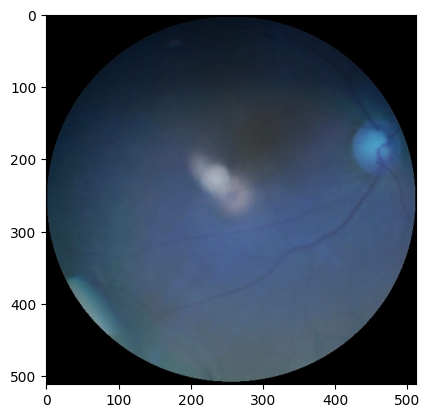

In [170]:
img = df_gla_filenames[342]
image = cv2.imread(os.path.join(img_dir, img))
plt.imshow(image)
print(image.shape)
print(img)

(512, 512, 3)
2120_right.jpg


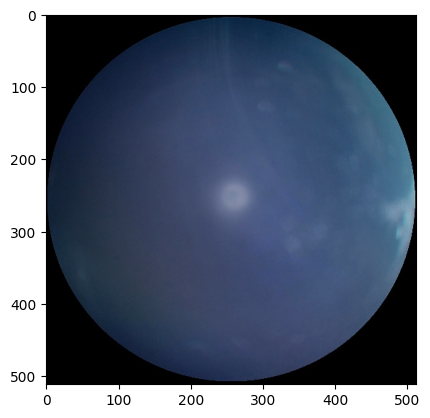

In [171]:
img = df_cat_filenames[342]
image = cv2.imread(os.path.join(img_dir, img))
plt.imshow(image)
print(image.shape)
print(img)

## Create grid of example images

From our cataract set of image file paths, let's create a comparitive grid to see what cataracts actually looks like.  We'll convert them to a more realistic RGB pallete as well.

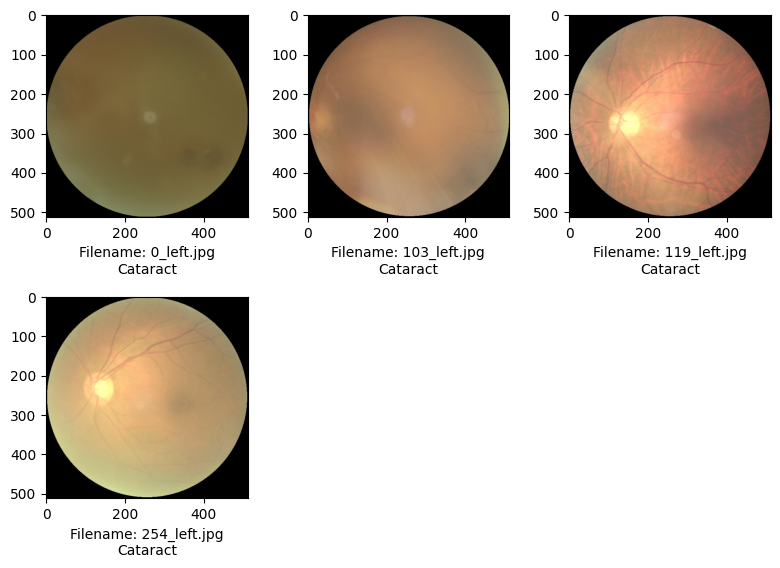

In [172]:
plt.figure(figsize=(8, 8))

for i in range(9):
    img = df_cat_filenames[i]
    image_path = os.path.join(img_dir, img)
    image = cv2.imread(image_path)

    # Check if the image was loaded successfully
    if image is not None:
        # Convert image to RGB
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Subplot variables - (# of rows, # of columns, iterate through locations on grid)
        plt.subplot(3, 3, i + 1)
        plt.imshow(image_rgb)

        # Label with filename and diagnosis
        plt.xlabel('Filename: {}\nCataract'.format(df_cat_filenames[i]))
    else:
        print(f"Warning: Unable to load image {image_path}")

plt.tight_layout()
plt.show()


## Gather the normal images
We now need to gather a set of normal images.  First let's see how many normal images there are available to us - we did this earlier but let's take a look again.  Remember, we're working with two eyes and we noticed that some of the encoded columns don't have data for both eyes, so the whole story is not truly told.  We need to look at the labeling in the keywords as that seems to be the source of truth when considering both eyes.

In [173]:
df_data[df_data == 1].sum(axis=0)

ID                              2.0
Patient Age                    28.0
Patient Sex                       0
Left-Fundus                       0
Right-Fundus                      0
Left-Diagnostic Keywords          0
Right-Diagnostic Keywords         0
N                            2101.0
D                            2123.0
G                             397.0
C                             402.0
A                             319.0
H                             203.0
M                             306.0
O                            1588.0
filepath                          0
labels                            0
target                            0
filename                          0
dtype: object

We see 2101 "normal" encoded results, but we can't really trust this since this may not take into account both eyes.  Let's check out the keyword results that contain "normal", separately for both eyes:

In [174]:
df_data2.head()

Patient Age Patient Sex Left-Fundus Right-Fundus  \
0           69      Female  0_left.jpg  0_right.jpg   
1           57        Male  1_left.jpg  1_right.jpg   
2           42        Male  2_left.jpg  2_right.jpg   
3           53        Male  4_left.jpg  4_right.jpg   
4           50      Female  5_left.jpg  5_right.jpg   

                            Left-Diagnostic Keywords  \
0                                           cataract   
1                                      normal fundus   
2  laser spot，moderate non proliferative retinopathy   
3                        macular epiretinal membrane   
4             moderate non proliferative retinopathy   

                Right-Diagnostic Keywords  
0                           normal fundus  
1                           normal fundus  
2  moderate non proliferative retinopathy  
3       mild nonproliferative retinopathy  
4  moderate non proliferative retinopathy

In [175]:
## let's place the Normal data into its own dataframe and print the number of rows

df_left_norm = df_data2[df_data2['Left-Diagnostic Keywords'].str.match('normal')]
print(len(df_left_norm))

2855


In [176]:
## let's place the Normal data into its own dataframe and print the number of rows

df_rt_norm = df_data2[df_data2['Right-Diagnostic Keywords'].str.match('normal')]
print(len(df_rt_norm))

2735


So if we add these up we have over 5000 images to choose from (comprised of both left and right side eye images) that are considered "normal".  This is far more than we have for our 'cataract' data that had only 572 images.  So, in that case let's pull an equal amount of randomly selected "normal" images.

## Combine normal filename data

In [177]:
df_cat_filenames = pd.concat([df_left_cat['Left-Fundus'], df_rt_cat['Right-Fundus']], ignore_index=True)
df_cat_filenames.head()

0      0_left.jpg
1    103_left.jpg
2    119_left.jpg
3    254_left.jpg
4    294_left.jpg
dtype: object

In [178]:
df_gla_filenames = pd.concat([df_left_gla['Left-Fundus'], df_rt_gla['Right-Fundus']], ignore_index=True)
df_gla_filenames.head()

0     153_left.jpg
1     167_left.jpg
2     583_left.jpg
3    1209_left.jpg
4    1210_left.jpg
dtype: object

## Select and create a random set

In [179]:
print(df_data.columns)

Index(['ID', 'Patient Age', 'Patient Sex', 'Left-Fundus', 'Right-Fundus',
       'Left-Diagnostic Keywords', 'Right-Diagnostic Keywords', 'N', 'D', 'G',
       'C', 'A', 'H', 'M', 'O', 'filepath', 'labels', 'target', 'filename'],
      dtype='object')


In [180]:
print(df_data['labels'].unique())


["['N']" "['D']" "['O']" "['M']" "['H']" "['C']" "['A']" "['G']"]


In [181]:
# Determine the number of samples available
available_samples = len(df_gla_filenames)
n_samples = min(490, available_samples)  # Choose either 572 or the available number if it's less

# Randomly sample imaes and reset the index
df_gla_filenames_random = df_gla_filenames.sample(n=n_samples, random_state=42).reset_index(drop=True)

# Display the first few entries
print(df_gla_filenames_random.head())

0    1362_right.jpg
1     1345_left.jpg
2    1273_right.jpg
3     1271_left.jpg
4    1325_right.jpg
dtype: object


In [182]:
## we will reset the index as well
df_gla_filenames_random = df_gla_filenames_random.reset_index(drop=True)
df_gla_filenames_random

0      1362_right.jpg
1       1345_left.jpg
2      1273_right.jpg
3       1271_left.jpg
4      1325_right.jpg
            ...      
485    2063_right.jpg
486     1230_left.jpg
487     1291_left.jpg
488     1334_left.jpg
489     1488_left.jpg
Length: 490, dtype: object

In [183]:
# Filter normal images where 'labels' is 'N'
df_cat_filenames = df_data[df_data['labels'] == "['C']"]['filename']

# Determine the number of samples available
available_samples = len(df_cat_filenames)
n_samples = min(490, available_samples)  # Choose either 572 or the available number if it's less

# Randomly sample images and reset the index
df_cat_filenames_random = df_cat_filenames.sample(n=n_samples, random_state=42).reset_index(drop=True)

# Display the first few entries
print(df_cat_filenames_random.head())

0    2173_right.jpg
1     2204_left.jpg
2    2116_right.jpg
3     1452_left.jpg
4        0_left.jpg
Name: filename, dtype: object


In [184]:
## we will reset the index as well
df_cat_filenames_random = df_cat_filenames_random.reset_index(drop=True)
df_cat_filenames_random

0      2173_right.jpg
1       2204_left.jpg
2      2116_right.jpg
3       1452_left.jpg
4          0_left.jpg
            ...      
288     2104_left.jpg
289    2155_right.jpg
290    2201_right.jpg
291     2217_left.jpg
292    2195_right.jpg
Name: filename, Length: 293, dtype: object

In [185]:
# Filter normal images where 'labels' is 'N'
df_norm_filenames = df_data[df_data['labels'] == "['N']"]['filename']

# Determine the number of samples available
available_samples = len(df_norm_filenames)
n_samples = min(494, available_samples)  # Choose either 572 or the available number if it's less

# Randomly sample images and reset the index
df_norm_filenames_random = df_norm_filenames.sample(n=n_samples, random_state=42).reset_index(drop=True)

# Display the first few entries
print(df_norm_filenames_random.head())


0    2812_right.jpg
1     2710_left.jpg
2    3419_right.jpg
3     2350_left.jpg
4    3038_right.jpg
Name: filename, dtype: object


In [186]:
## we will reset the index as well
df_norm_filenames_random = df_norm_filenames_random.reset_index(drop=True)
df_norm_filenames_random

0      2812_right.jpg
1       2710_left.jpg
2      3419_right.jpg
3       2350_left.jpg
4      3038_right.jpg
            ...      
489     2658_left.jpg
490     4683_left.jpg
491       56_left.jpg
492    2475_right.jpg
493    2839_right.jpg
Name: filename, Length: 494, dtype: object

Looks like the random sampling

## Create a grid of "normal" images

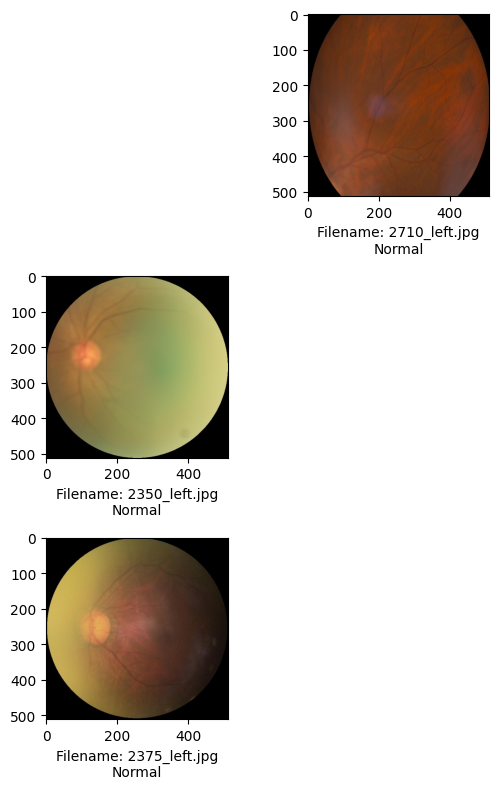

In [187]:
plt.figure(figsize=(8, 8))

for i in range(9):
    img = df_norm_filenames_random[i]
    image_path = os.path.join(img_dir, img)
    image = cv2.imread(image_path)

    # Check if the image was loaded successfully
    if image is not None:
        # Convert image to RGB
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Subplot variables - (# of rows, # of columns, iterate through locations on grid)
        plt.subplot(3, 3, i + 1)
        plt.imshow(image_rgb)

        # Label with filename and diagnosis
        plt.xlabel('Filename: {}\nNormal'.format(img))
    else:
        print(f"Warning: Unable to load image {image_path}")

plt.tight_layout()
plt.show()


## Add category label to list

Previously created these two objects that weren't true dataframes, they became lists after we did an append of columns.  For convenience, need to turn them back into dataframes:

- df_norm_filenames_random
- df_cat_filenames

Images will be labeled normal or cataract, in this case  will be using an image data generator that will do the one-hot-encoding for us, so we can preserve the actual "word" string labels.

In [188]:
df_cat_filenames = pd.DataFrame(df_cat_filenames, columns = ["filename"])
#df_cat_filenames.set_index("filename", inplace = True)

# add a new column of '1' to the dataframe
df_cat_filenames["label"] = "cataract"

df_cat_filenames.head()

filename     label
20    24_right.jpg  cataract
93   112_right.jpg  cataract
160  188_right.jpg  cataract
186  218_right.jpg  cataract
309  354_right.jpg  cataract

In [189]:
df_gla_filenames = pd.DataFrame(df_gla_filenames, columns = ["filename"])
#df_cat_filenames.set_index("filename", inplace = True)

# add a new column of '1' to the dataframe
df_gla_filenames["label"] = "glaucoma"

df_gla_filenames.head()

filename     label
0   153_left.jpg  glaucoma
1   167_left.jpg  glaucoma
2   583_left.jpg  glaucoma
3  1209_left.jpg  glaucoma
4  1210_left.jpg  glaucoma

In [190]:
df_norm_filenames_random = pd.DataFrame(df_norm_filenames_random, columns = ["filename"])
#df_cat_filenames.set_index("filename", inplace = True)

# add a new column of '1' to the dataframe
df_norm_filenames_random["label"] = "normal"

df_norm_filenames_random.head()

filename   label
0  2812_right.jpg  normal
1   2710_left.jpg  normal
2  3419_right.jpg  normal
3   2350_left.jpg  normal
4  3038_right.jpg  normal

## Append dataframes into a single dataset

 have both cataract and normal dataframes with labels, we need to combine them to form a single dataframe to feed into our image generator.


In [191]:
# Combine df_cat_filenames and df_norm_filenames_random using pd.concat()

df_combined = pd.concat([df_cat_filenames,df_gla_filenames, df_norm_filenames_random], ignore_index=True)
# df_combined = pd.concat([df_cat_filenames, df_norm_filenames_random], ignore_index=True)

# Display the combined DataFrame
print(df_combined)


            filename     label
0       24_right.jpg  cataract
1      112_right.jpg  cataract
2      188_right.jpg  cataract
3      218_right.jpg  cataract
4      354_right.jpg  cataract
...              ...       ...
1276   2658_left.jpg    normal
1277   4683_left.jpg    normal
1278     56_left.jpg    normal
1279  2475_right.jpg    normal
1280  2839_right.jpg    normal

[1281 rows x 2 columns]


## Randomize our final combined dataset

Prior to feeding this organized set of cataract and normal images we need to randomize the rows within so that when we train we will train from a random pool of samples.

If we append, we end up adding a column for the old index values, which we don't want any new columns, so we'll drop the old index and allow the new dataframe to have a new one.

In [192]:
df_combined_random = df_combined.sample(frac=1).reset_index(drop=True)
df_combined_random

filename     label
0     1485_right.jpg  glaucoma
1     1269_right.jpg  glaucoma
2     2239_right.jpg  cataract
3     2246_right.jpg  cataract
4        59_left.jpg    normal
...              ...       ...
1276  1230_right.jpg  glaucoma
1277   2793_left.jpg    normal
1278    153_left.jpg  glaucoma
1279  2952_right.jpg    normal
1280  1291_right.jpg  glaucoma

[1281 rows x 2 columns]

## Split our dataframe into test, train, validation dataframes

Since going to continue to use a dataframe with a labels column,  can't use the common sklearn test-train-split function,will instead simplify things and create three data frames by pulling random samples out and then excluding those samples from another set by using the drop method.

In [193]:
# pull 80% of the combined dataset and reserve it for the training data
# the data generator will automatically create a validation set for us later

df_train = df_combined_random.sample(frac=0.8,random_state=42)
df_train.reset_index(drop=True)

# exclude the 80% that was already chosen, the remaining 20% will go into testing
df_test = df_combined_random.drop(df_train.index)
df_test.reset_index(drop=True)

print(len(df_combined_random))
print(len(df_train))
print(len(df_test))

1281
1025
256


## Image Generator flow from Dataframe

This was developed by:  https://vijayabhaskar96.medium.com/tutorial-on-keras-flow-from-dataframe-1fd4493d237c


add some parameters that will perform some adjustment to the images.

In [194]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255.,
    validation_split=0.20,
    rotation_range=90,
    width_shift_range=0.3,         # Increase shift range to 30%
    height_shift_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.3,               # Increase shear range to 30%
    brightness_range=[0.2, 1.2],   # Widen brightness range for more variety
    zoom_range=[0.5, 1.2],         # Allow zoom out to 50% and in to 120%
    channel_shift_range=0.1,       # Randomly adjust color channels
    fill_mode='nearest',           # Fill any gaps created by transformations
)

test_datagen=ImageDataGenerator(rescale=1./255.)

In [195]:
# train_datagen=tf.keras.preprocessing.image.ImageDataGenerator(
#             rescale=1./255.,
#             validation_split=0.20,
#             rotation_range=90,
#             width_shift_range=0.2,
#             height_shift_range=0.2,
#             horizontal_flip=True,
#             vertical_flip=True,
#             shear_range=0.2,
#             brightness_range=[0.3,1],
#             zoom_range=0.2
#             )

# ## for testing we don't want to do too much augmentation, we'll just scale it.

# test_datagen=ImageDataGenerator(rescale=1./255.)

## Convert row objects to string type

Although flow from dataframe will work with other datatypes, I kept getting errors that were requesting to convert the dataframe rows into string type.

In [196]:
df_train['label'] = df_train['label'].astype(str)
df_test['label'] = df_test['label'].astype(str)

## Create test, train and validation image data generators

In [197]:
train_generator=train_datagen.flow_from_dataframe(
dataframe=df_train,
directory=img_dir,
x_col="filename",
y_col="label",
subset="training",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(img_size,img_size))

## validation set is created from the training set,
## we set it at 20% of the training data in the previous code

valid_generator=train_datagen.flow_from_dataframe(
dataframe=df_train,
directory=img_dir,
x_col="filename",
y_col="label",
subset="validation",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(img_size,img_size))


test_generator=test_datagen.flow_from_dataframe(
dataframe=df_test,
directory=img_dir,
x_col="filename",
y_col="label",
batch_size=32,
#seed=42,
shuffle=False,
class_mode="categorical",
target_size=(img_size,img_size))

Found 599 validated image filenames belonging to 3 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 277 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


Found 149 validated image filenames belonging to 3 classes.
Found 185 validated image filenames belonging to 3 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 277 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 71 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


## Image generator results

Let's look at the actual data that gets created from the image generator.  The "next" command splits the generator data into two numpy arrays - one with image data and one with label data.

In [198]:
# Use the built-in next() function to get the next batch from train_generator
train_image_data, train_labels = next(train_generator)

# Display the shape of the image data
print(train_image_data.shape)


(32, 224, 224, 3)


Let's look at the label format

In [199]:
train_labels[0]

array([0., 0., 1.], dtype=float32)

Let's grab a single augmented image

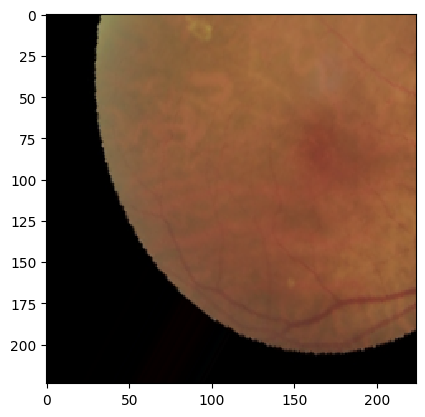

In [200]:
plt.imshow(train_image_data[0], interpolation='nearest')
plt.show()
#images = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

## Augmented image examples

Let's make a grid of data augmented images

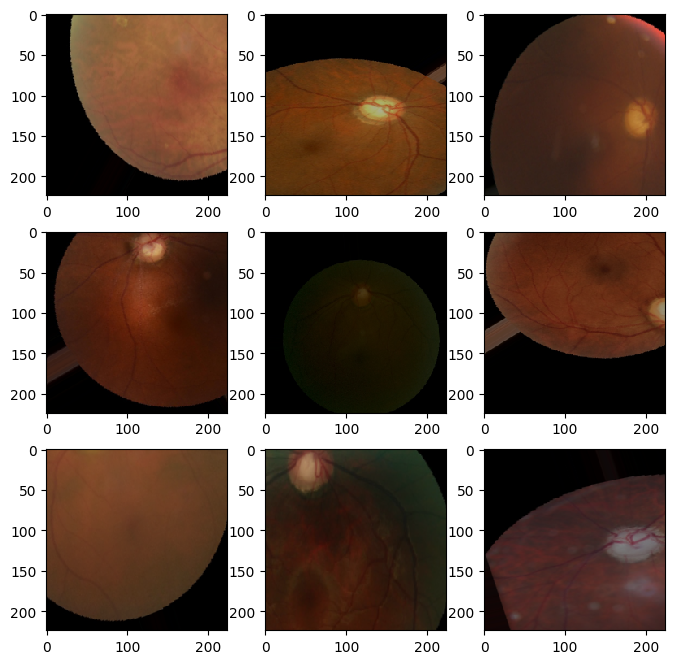

In [201]:
plt.figure(figsize=(8,8))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(train_image_data[i], interpolation='nearest')

plt.show()

## The VGG16 model diagram

![](https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png)

https://neurohive.io/en/popular-networks/vgg16/

## Build our transfer learning model

Here the vgg16 model, but since we are doing transfer learning, we don't want the fully connected portion, so we will rip it off with the include_top FALSE option.  We don't want this because we have a custom dataset that has a custom number of outputs, 2 in this case.

We will use the 'imagenet' weights since those filters / weights / kernels will help us find edges, corners, rounded areas of our images.  Those are already baked in and we can speed this process up by using some that are proven to be effective for thousands of images.

We will drop 50% of the perceptrons during the final layer to avoid overfitting.

We will use the ADAM gradient descent optimizer as well.

In [202]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight('balanced', classes=np.unique(y_train_true), y=y_train_true)
class_weights = dict(enumerate(class_weights))

In [203]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam

# Get InceptionV3 base model
inceptionv3 = InceptionV3(input_shape=(224, 224, 3),
                          weights='imagenet',
                          include_top=False)

# Add new dense layers on top of InceptionV3
x = layers.Flatten()(inceptionv3.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)

# Update for 3-label output and multiclass classification
predictions = layers.Dense(3, activation='softmax')(x)  # Change to 3 units for 3 classes

# Define and compile the model
model = Model(inputs=inceptionv3.inputs, outputs=predictions)

# Freeze InceptionV3 base layers to retain pretrained features
for layer in inceptionv3.layers:
    layer.trainable = False

# Compile the model with settings suitable for multiclass classification
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',  # Use categorical_crossentropy for multiclass
              metrics=['accuracy'])


In [204]:
# # get VGG16 base model
# vgg16 = keras.applications.vgg16.VGG16(input_shape=(224, 224, 3),
#                                        weights='imagenet',
#                                        include_top=False)

# # add new dense layers at the top
# x = keras.layers.Flatten()(vgg16.output)
# x = keras.layers.Dense(1024, activation='relu')(x)
# x = keras.layers.Dropout(0.5)(x)
# x = keras.layers.Dense(128, activation='relu')(x)

# ## remember we are using 2 outputs only
# predictions = keras.layers.Dense(2, activation='softmax')(x)

# # define and compile model
# model = keras.Model(inputs=vgg16.inputs, outputs=predictions)
# for layer in vgg16.layers:
#     layer.trainable = False

# model.compile(optimizer='adam',
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

## Create check point and early stop

A check point allows us to monitor the acuraccy and perform some task, in this case we will save the model as a file.

The early stop will monitor accuracy for a 'patience' parameter and if there is no improvement it will stop.

In [205]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Update ModelCheckpoint for InceptionV3
checkpoint = ModelCheckpoint("inceptionv3_best_model.keras",
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto',
                             save_freq='epoch')

# EarlyStopping callback
early = EarlyStopping(monitor='val_accuracy',
                      min_delta=0,
                      patience=10,
                      verbose=1,
                      mode='auto')


In [206]:
# from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# # Update ModelCheckpoint
# checkpoint = ModelCheckpoint("vgg16_1.keras",
#                              monitor='val_accuracy',
#                              verbose=1,
#                              save_best_only=True,
#                              save_weights_only=False,
#                              mode='auto',
#                              save_freq='epoch')

# # EarlyStopping callback
# early = EarlyStopping(monitor='val_accuracy',
#                       min_delta=0,
#                       patience=10,
#                       verbose=1,
#                       mode='auto')




From:  https://stackoverflow.com/questions/46820609/how-the-keras-steps-per-epoch-in-fit-generator-works

The steps_per_epoch parameter is the number of batches of samples it will take to complete one full epoch. This is dependent on your batch size. The batch size is set where you initialize your training data. For example, if you're doing this with ImageDataGenerator.flow() or ImageDataGenerator.flow_from_directory(), the batch size is specified with the batch_size parameter in each of these.

With 3000 samples for example:

```
If your batch size was 100, then steps_per_epoch would be 30.
If your batch size was 10, then steps_per_epoch would be 300.
If your batch size was 1, then steps_per_epoch would be 3000.
```

This is because steps_per_epoch should be equivalent to the total number of samples divided by the batch size. The process of implementing this in Keras is available in the two videos below.

## Constants for our training run

SPE is 'steps per epoch'

n_val_steps is 'number of validation steps'

In [207]:
batch_size = 32
n_spe = train_generator.samples // batch_size
n_val_steps = valid_generator.samples // batch_size
n_epochs = 30

print(n_spe,n_val_steps)

18 4


In [208]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam

# Initialize InceptionV3 base model with pre-trained weights and without the top layer
inceptionv3_base = InceptionV3(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

# Add custom layers on top of InceptionV3
x = layers.Flatten()(inceptionv3_base.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
predictions = layers.Dense(3, activation='softmax')(x)  # Assuming 3 classes

# Define the complete model
InceptionV3_final_model = Model(inputs=inceptionv3_base.input, outputs=predictions)

# Freeze the InceptionV3 base layers
for layer in inceptionv3_base.layers:
    layer.trainable = False

# # Compile the model
# InceptionV3_final_model.compile(optimizer=Adam(learning_rate=0.0001),
#                                 loss='categorical_crossentropy',
#                                 metrics=['accuracy'])

# Check if the model is defined properly
print(InceptionV3_final_model.summary())


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_564 (Conv2D)       │ (None, 111, 111, 32)   │            864 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_564   │ (None, 111, 111, 32)   │             96 │ conv2d_564[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_564            │ (None, 111, 111, 32)   │              0 │ batch_normalization_5… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_565 (Conv2D)       │ (None, 109, 109, 32)   │          9,216 │ activation_564[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_565   │ (None, 109, 109, 32)   │             96 │ conv2d_565[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_565            │ (None, 109, 109, 32)   │              0 │ batch_normalization_5… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_566 (Conv2D)       │ (None, 109, 109, 64)   │         18,432 │ activation_565[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_566   │ (None, 109, 109, 64)   │            192 │ conv2d_566[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_566            │ (None, 109, 109, 64)   │              0 │ batch_normalization_5… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_24          │ (None, 54, 54, 64)     │              0 │ activation_566[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_567 (Conv2D)       │ (None, 54, 54, 80)     │          5,120 │ max_pooling2d_24[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_567   │ (None, 54, 54, 80)     │            240 │ conv2d_567[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_567            │ (None, 54, 54, 80)     │              0 │ batch_normalization_5… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_568 (Conv2D)  

 Total params: 74,364,195 (283.68 MB)

 Trainable params: 52,561,411 (200.51 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

None


In [209]:
from tensorflow.keras.optimizers import Adam

for layer in InceptionV3_final_model.layers[:249]:
    layer.trainable = False
for layer in InceptionV3_final_model.layers[249:]:
    layer.trainable = True

InceptionV3_final_model.compile(optimizer=Adam(learning_rate=1e-5),
                                loss='categorical_crossentropy',
                                metrics=['accuracy'])


In [210]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)


In [211]:
x = layers.Flatten()(inceptionv3_base.output)
x = layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(3, activation='softmax')(x)  # Adjust based on the number of classes


In [212]:
x = layers.Flatten()(inceptionv3_base.output)
x = layers.BatchNormalization()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)


In [213]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight('balanced', classes=np.unique(y_train_true), y=y_train_true)
class_weights = dict(enumerate(class_weights))


In [214]:
# hist = InceptionV3_final_model.fit(
#     train_generator,
#     steps_per_epoch=n_spe,
#     validation_data=valid_generator,
#     validation_steps=n_val_steps,
#     epochs=n_epochs,
#     shuffle=True,
#     callbacks=[checkpoint, early]
# )

hist = InceptionV3_final_model.fit(train_generator, validation_data=valid_generator, epochs=n_epochs,
                            class_weight=class_weights, callbacks=[checkpoint, early, reduce_lr])


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3327 - loss: 1.4077
Epoch 1: val_accuracy improved from -inf to 0.47651, saving model to inceptionv3_best_model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 99s 3s/step - accuracy: 0.3347 - loss: 1.4017 - val_accuracy: 0.4765 - val_loss: 0.9946 - learning_rate: 1.0000e-05
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.3929 - loss: 1.0825
Epoch 2: val_accuracy improved from 0.47651 to 0.59060, saving model to inceptionv3_best_model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.3941 - loss: 1.0805 - val_accuracy: 0.5906 - val_loss: 0.8218 - learning_rate: 1.0000e-05
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 608ms/step - accuracy: 0.5168 - loss: 1.0236
Epoch 3: val_accuracy did not improve from 0.59060
19/19 ━━━━━━━━━━━━━━━━━━━━ 19s 753ms/step - accuracy: 0.5163 - loss: 1.0225 - val_accuracy: 0.5705 - val_loss: 0.8518 - learning_rate: 1.0000e-05
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.4791 - l

In [215]:
# hist = model.fit(
#     train_generator,
#     steps_per_epoch=n_spe,
#     validation_data=valid_generator,
#     validation_steps=n_val_steps,
#     epochs=n_epochs,
#     shuffle=True,
#     callbacks=[checkpoint, early]
# )


19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 796ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step


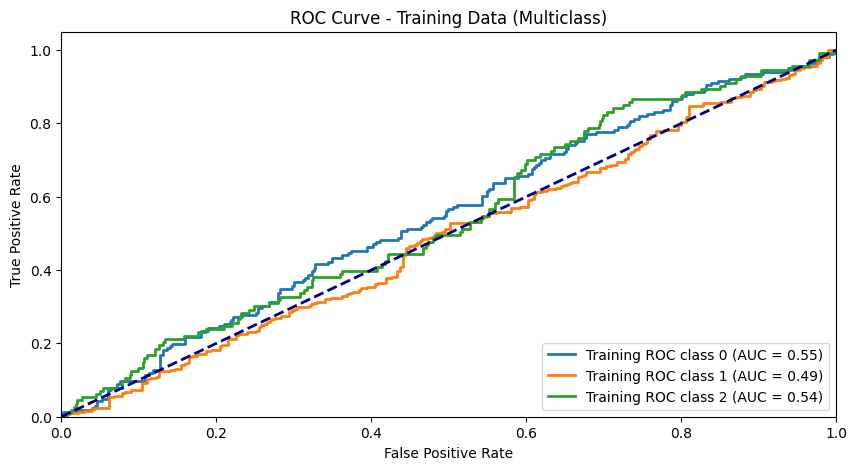

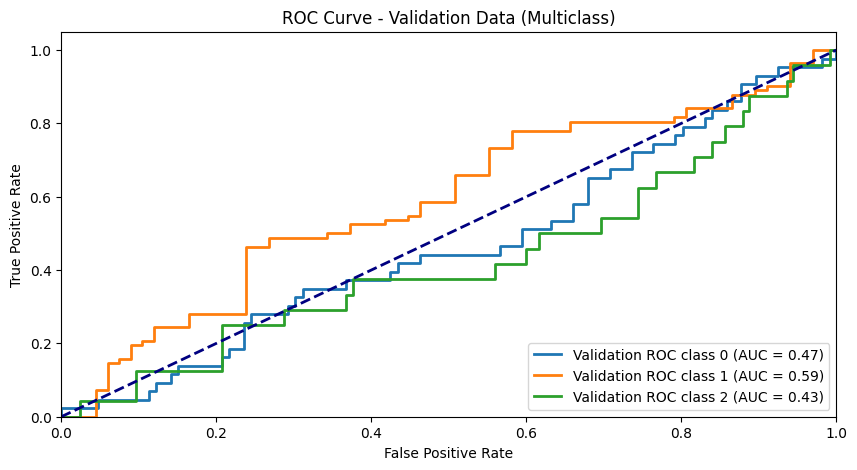

In [216]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Generate predictions for training and validation data
y_train_pred = InceptionV3_final_model.predict(train_generator)
y_valid_pred = InceptionV3_final_model.predict(valid_generator)

# True labels for training and validation
y_train_true = train_generator.classes
y_valid_true = valid_generator.classes

# Convert true labels to one-hot encoding if they aren't already
y_train_true_one_hot = tf.keras.utils.to_categorical(y_train_true, num_classes=3)
y_valid_true_one_hot = tf.keras.utils.to_categorical(y_valid_true, num_classes=3)

# Separate plot for Training ROC curves
plt.figure(figsize=(10, 5))
for i in range(3):  # Assuming 3 classes
    # Training data ROC and AUC for class i
    fpr_train, tpr_train, _ = roc_curve(y_train_true_one_hot[:, i], y_train_pred[:, i])
    roc_auc_train = auc(fpr_train, tpr_train)

    # Plot ROC curve for training
    plt.plot(fpr_train, tpr_train, lw=2, label=f'Training ROC class {i} (AUC = {roc_auc_train:.2f})')

# Diagonal line for random guessing
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Plot settings for training
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Training Data (Multiclass)')
plt.legend(loc="lower right")
plt.show()

# Separate plot for Validation ROC curves
plt.figure(figsize=(10, 5))
for i in range(3):  # Assuming 3 classes
    # Validation data ROC and AUC for class i
    fpr_valid, tpr_valid, _ = roc_curve(y_valid_true_one_hot[:, i], y_valid_pred[:, i])
    roc_auc_valid = auc(fpr_valid, tpr_valid)

    # Plot ROC curve for validation
    plt.plot(fpr_valid, tpr_valid, lw=2, label=f'Validation ROC class {i} (AUC = {roc_auc_valid:.2f})')

# Diagonal line for random guessing
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Plot settings for validation
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Validation Data (Multiclass)')
plt.legend(loc="lower right")
plt.show()



19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 497ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 596ms/step


<Figure size 800x800 with 0 Axes>

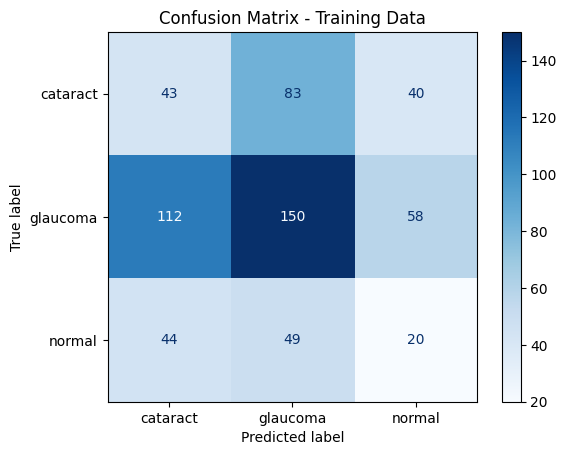

<Figure size 800x800 with 0 Axes>

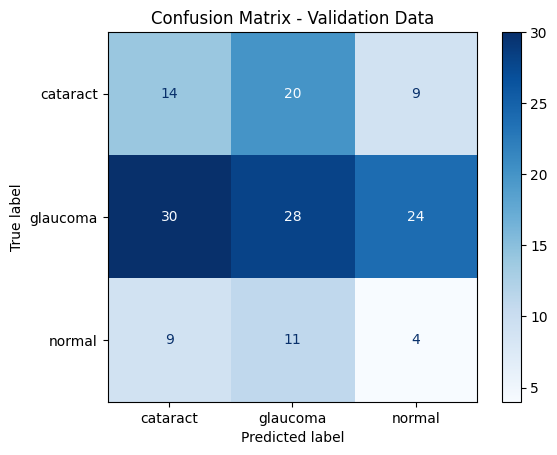

In [217]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Generate predictions and true labels for training data
y_train_pred = InceptionV3_final_model.predict(train_generator)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)
y_train_true_classes = train_generator.classes

# Generate predictions and true labels for validation data
y_valid_pred = InceptionV3_final_model.predict(valid_generator)
y_valid_pred_classes = np.argmax(y_valid_pred, axis=1)
y_valid_true_classes = valid_generator.classes

# Confusion Matrix for Training Data
conf_matrix_train = confusion_matrix(y_train_true_classes, y_train_pred_classes)
disp_train = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_train, display_labels=train_generator.class_indices.keys())

plt.figure(figsize=(8, 8))
disp_train.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Training Data")
plt.show()

# Confusion Matrix for Validation Data
conf_matrix_valid = confusion_matrix(y_valid_true_classes, y_valid_pred_classes)
disp_valid = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_valid, display_labels=valid_generator.class_indices.keys())

plt.figure(figsize=(8, 8))
disp_valid.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Validation Data")
plt.show()


## Load our saved model

In [218]:
from keras.models import load_model
model = load_model('./vgg16_1.keras')


**ROC Curve for Normal and Cataract Classes**

19/19 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step


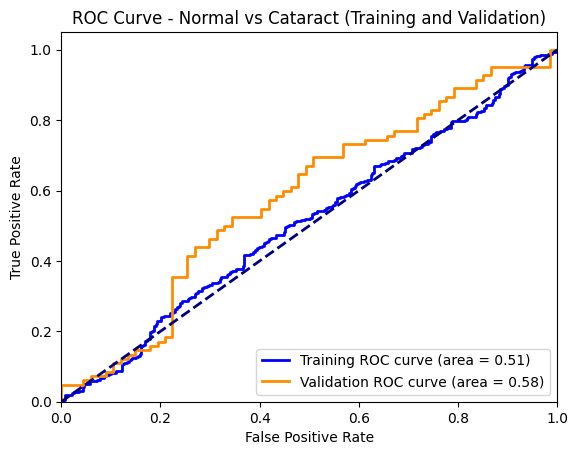

In [219]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Assuming train_generator and valid_generator are defined
# Generate predictions for training data
y_train_pred = model.predict(train_generator)
y_train_true = train_generator.classes
y_train_pred_prob = y_train_pred[:, 1]  # Assuming "Cataract" is the second class

# Calculate ROC curve and AUC for training data
fpr_train, tpr_train, thresholds_train = roc_curve(y_train_true, y_train_pred_prob, pos_label=1)
roc_auc_train = auc(fpr_train, tpr_train)

# Generate predictions for validation data
y_valid_pred = model.predict(valid_generator)
y_valid_true = valid_generator.classes
y_valid_pred_prob = y_valid_pred[:, 1]

# Calculate ROC curve and AUC for validation data
fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid_true, y_valid_pred_prob, pos_label=1)
roc_auc_valid = auc(fpr_valid, tpr_valid)

# Plot the ROC curves for training and validation datasets
plt.figure()

# Plot for training
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Training ROC curve (area = {roc_auc_train:.2f})')

# Plot for validation
plt.plot(fpr_valid, tpr_valid, color='darkorange', lw=2, label=f'Validation ROC curve (area = {roc_auc_valid:.2f})')

# Diagonal line representing random guess
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Normal vs Cataract (Training and Validation)')
plt.legend(loc="lower right")
plt.show()


# **Grad-CAM (Gradient-weighted Class Activation Mapping)** (still testing)

Shape of preds: (1, 1, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Shape of preds: (1, 1, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Shape of preds: (1, 1, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Shape of preds: (1, 1, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Shape of preds: (1, 1, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Shape of preds: (1, 1, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Shape of preds: (1, 1, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Shape of preds: (1, 1, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Shape of preds: (1, 1, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


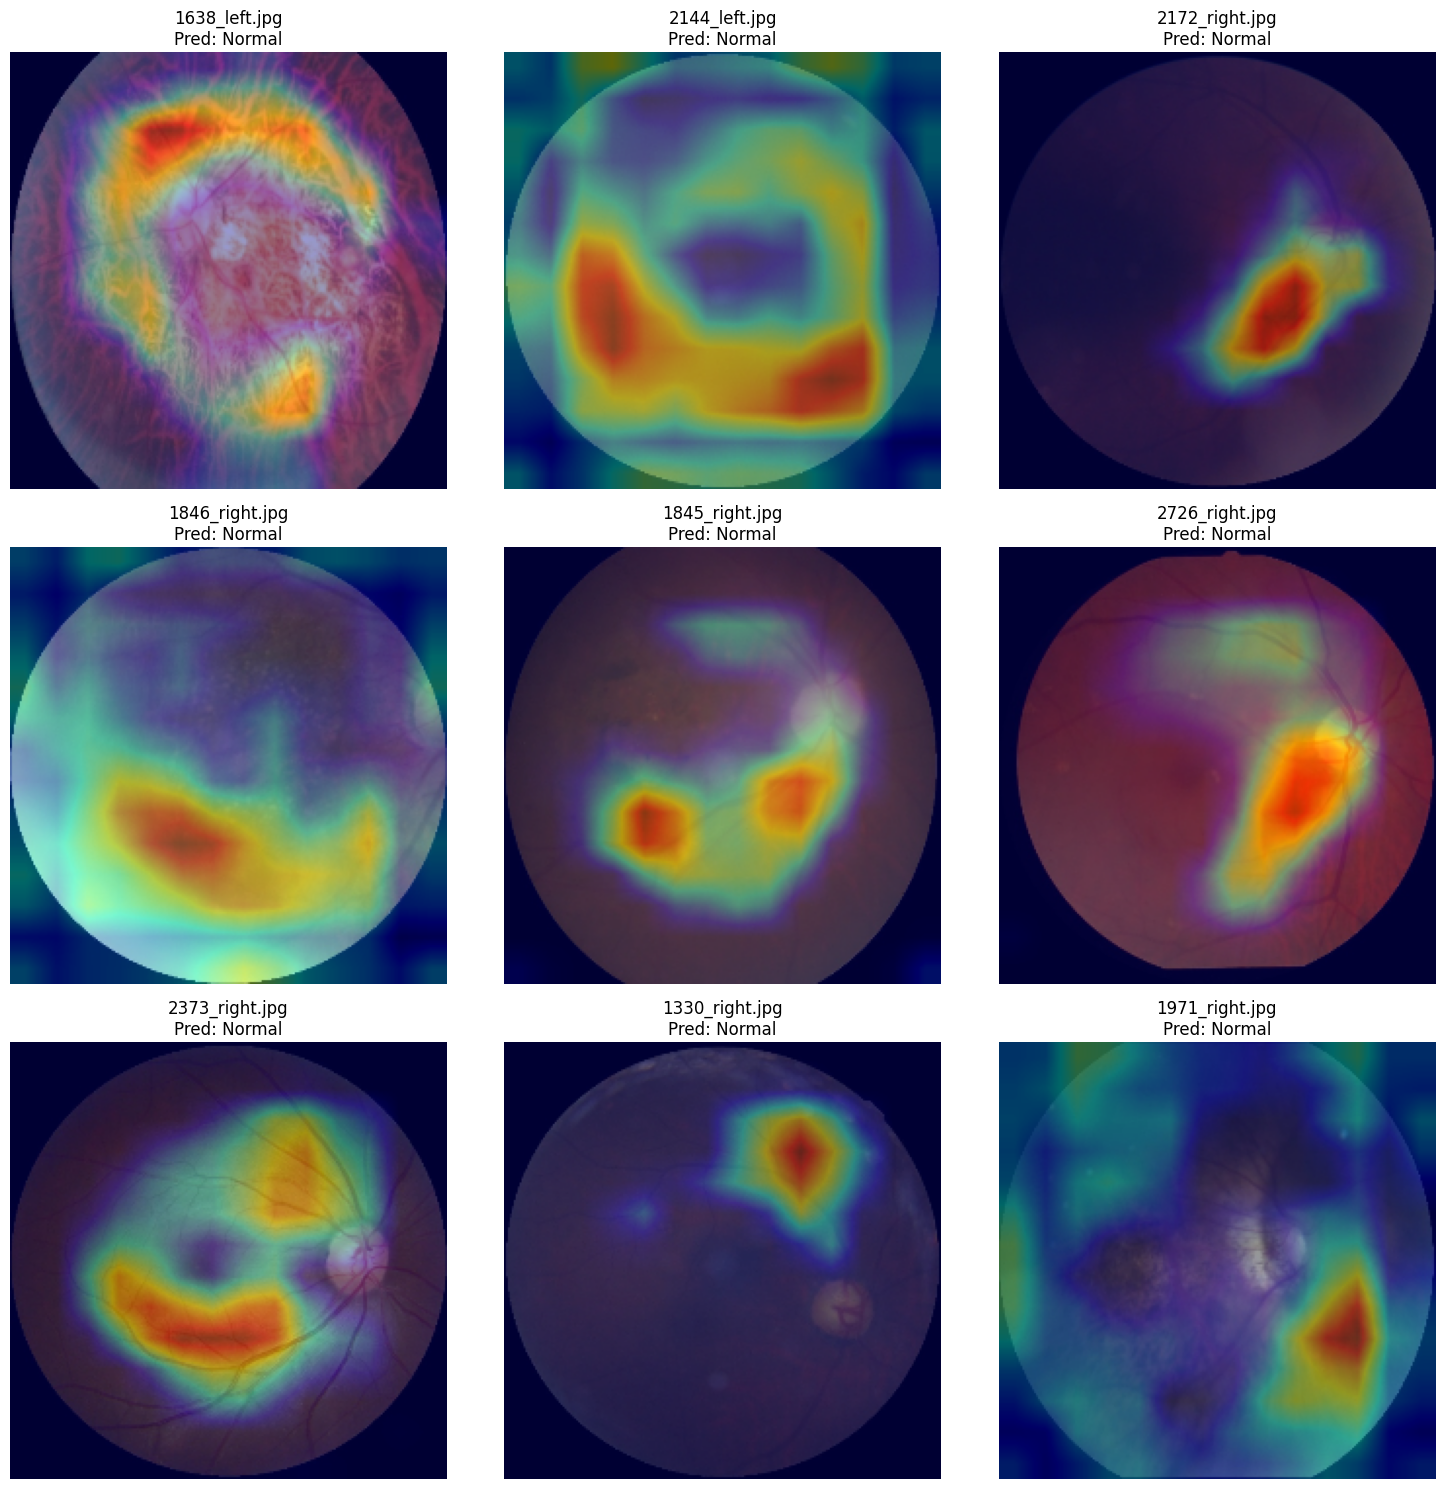

In [220]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input

def get_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)

        preds = tf.convert_to_tensor(preds)
        print("Shape of preds:", preds.shape)

        if pred_index is None:
            pred_index = int(tf.argmax(tf.reshape(preds, [-1])).numpy())

        class_channel = preds[0, 0, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam_grid(directory_path, model, last_conv_layer_name='block5_conv3', class_labels=['Normal', 'Cataract']):
    all_images = [os.path.join(directory_path, fname) for fname in os.listdir(directory_path) if fname.endswith(('.jpg', '.jpeg', '.png'))]

    if len(all_images) < 9:
        raise ValueError("Not enough images in the directory to sample 9 for the grid.")

    image_paths = random.sample(all_images, 9)
    plt.figure(figsize=(15, 15))

    for i, img_path in enumerate(image_paths):
        img_name = os.path.basename(img_path)

        img = load_img(img_path, target_size=(224, 224))
        img_array = np.expand_dims(img_to_array(img), axis=0)
        img_array = preprocess_input(img_array)

        heatmap = get_gradcam_heatmap(img_array, model, last_conv_layer_name)

        preds = model.predict(img_array)
        pred_class = class_labels[np.argmax(preds[0][0])]  # Predicted class label

        original_img = cv2.imread(img_path)
        original_img = cv2.resize(original_img, (224, 224))

        heatmap_resized = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
        heatmap_resized = np.uint8(255 * heatmap_resized)
        heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

        superimposed_img = cv2.addWeighted(original_img, 0.6, heatmap_colored, 0.4, 0)

        plt.subplot(3, 3, i + 1)
        plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
        plt.title(f"{img_name}\nPred: {pred_class}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage with the class labels provided
directory_path = "/content/drive/MyDrive/CS5100/preprocessed_images"
display_gradcam_grid(directory_path, model, last_conv_layer_name='block5_conv3', class_labels=['Normal', 'Cataract'])


## Plot accuracy versus loss

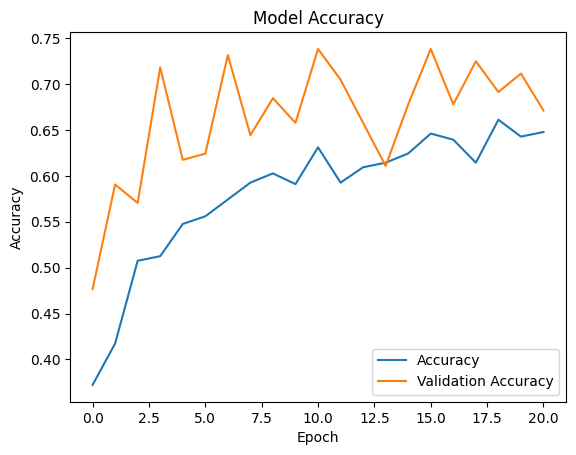

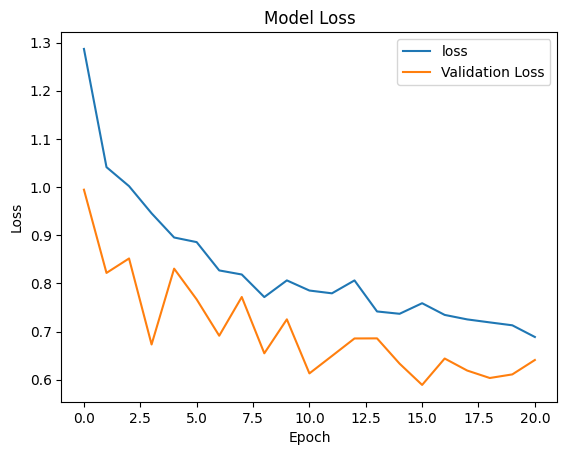

In [221]:
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["loss","Validation Loss"])
plt.show()